In [5]:
from selenium import webdriver
driver = webdriver.Chrome('./chromedriver')

import time
driver.get('https://www.instagram.com/')
time.sleep(2)

In [6]:
# 인스타그램 검색 URL 만들기
def insta_searching(word):
    url = 'https://www.instagram.com/explore/tags/' + word
    return url

In [39]:
word = '보길도맛집' # 홍도여행, 홍도맛집, 흑산도여행, 흑산도맛집, 보길도여행, 보길도맛집
url = insta_searching(word)
driver.get(url)
time.sleep(3)

In [40]:
# 첫번째 게시글 열기
def select_first(driver):
    first = driver.find_element_by_css_selector('div._9AhH0')
    first.click()
    time.sleep(3)

select_first(driver)

In [14]:
import re # 정규표현식에 사용되는 라이브러리 
from bs4 import BeautifulSoup
import unicodedata

#게시물 가져오기
def get_content(driver):
    # 1. 현재 페이지의 HTML 정보 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 2. 본문 내용 가져오기
    try:
        content = soup.select('div.C4VMK > span')[0].text
        content = unicodedata.normalize('NFC', content) # MacOS에서 작성된 글의 경우, 한글 자음/모음 분리되는 현상이 있어서 자음/모음을 합쳐서 한글을 처리하는(NFC방식) 코드
    except:
        content = ' '
    
    # 3. 본문 내용에서 해시태그 가져오기
    tags = re.findall(r'#[^\s#,\\]+', content)
    
    # 4. 작성일자 정보 가져오기
    date = soup.select('time._1o9PC.Nzb55')[0]['datetime'][:10]
    
    # 5. 좋아요 수 가져오기
    try:
        like = soup.select('div.Nm9Fw > button')[0].text[4:-1] # 좋아요 xx개 형태에서 숫자만 가져오기
    except:
        like = 0
    
    # 6. 위치정보 가져오기
    try:
        place = soup.select('div.M30cS')[0].text
        place = unicodedata.normalize('NFC', place)
    except:
        place = ''
    
    # 7. 수집한 정보 저장
    data = [content, date, like, place, tags]
    return data

In [23]:
# 다음 페이지로 이동하기
def move_next(driver):
    right = driver.find_element_by_css_selector('a.coreSpriteRightPaginationArrow')
    right.click()
    time.sleep(3)

In [41]:
results = []
target = 150 # 크롤링할 게시글 수
for i in range(target):
    # 게시글 수집에 오류 발생 시 (네트워크 문제 등) 2초 대기후 다음 게시글 넘어가도록 try-catch
    try:
        data = get_content(driver)
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)

print(results[:2])

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"a.coreSpriteRightPaginationArrow"}
  (Session info: chrome=92.0.4515.159)


In [42]:
import pandas as pd
FILE_DIR = './practice/'
# 크롤링 결과 저장
results_df = pd.DataFrame(results)
results_df.columns = ['content', 'date', 'like', 'place', 'tags']
results_df.to_excel(FILE_DIR + f'1_crawling_{word}.xlsx', index=False)

In [44]:
insta_df = pd.DataFrame([])

f_list = ['1_crawling_홍도여행.xlsx', '1_crawling_홍도맛집.xlsx', '1_crawling_흑산도여행.xlsx', '1_crawling_흑산도맛집.xlsx', '1_crawling_보길도여행.xlsx', '1_crawling_보길도맛집.xlsx']

for name in f_list:
    fpath = FILE_DIR + name
    temp = pd.read_excel(fpath)
    insta_df = insta_df.append(temp)

insta_df.columns = ['content', 'date', 'like', 'place', 'tags']

In [45]:
insta_df.drop_duplicates(subset=['content'], inplace=True)
insta_df.to_excel(FILE_DIR + '1_crawling_raw.xlsx', index=False)

In [46]:
raw_total = pd.read_excel(FILE_DIR + '1_crawling_raw.xlsx')

location_counts = raw_total['place'].value_counts() # 위치 정보별 빈도수
location_counts

Hongdo                                        42
홍도                                            36
보길도                                           35
흑산도                                           22
Heuksando Island                              14
Heuksando                                     13
보길도 세연정                                       10
흑산도항                                           7
노화도                                            6
홍도 등대                                          5
예송갯돌해변                                         4
Nohwado, South Korea                           3
아름다운 흑산도                                       3
통리솔밭해변                                         2
해남 땅끝마을->보길도                                   2
목포여객선터미널                                       2
을왕리해수욕장                                        2
다도해해상국립공원                                      2
흑산도전망대                                         2
곡수당                                            2
공룡알해변               

In [47]:
location_counts_df = pd.DataFrame(location_counts)
location_counts_df.head()

,place
Hongdo,42
홍도,36
보길도,35
흑산도,22
Heuksando Island,14


In [48]:
location_counts_df.to_excel(FILE_DIR + '3_location_counts.xlsx')

In [49]:
locations = list(location_counts.index) # 위치 정보만
locations

['Hongdo',
 '홍도',
 '보길도',
 '흑산도',
 'Heuksando Island',
 'Heuksando',
 '보길도 세연정',
 '흑산도항',
 '노화도',
 '홍도 등대',
 '예송갯돌해변',
 'Nohwado, South Korea',
 '아름다운 흑산도',
 '통리솔밭해변',
 '해남 땅끝마을->보길도',
 '목포여객선터미널',
 '을왕리해수욕장',
 '다도해해상국립공원',
 '흑산도전망대',
 '곡수당',
 '공룡알해변',
 '낙서재',
 'Wando',
 '동천석실',
 '중리은모래해변',
 '완도 보길도',
 '전라남도 완도군 보길도',
 '망끝전망대',
 'Mokpo',
 '세연정횟집앤모텔',
 'Nohwa-do',
 '흑산조합영어법인',
 '갯돌사랑',
 '소안도',
 'Хыксандо',
 'Naju',
 'Korea - 한국',
 '보길도예송리',
 'hyimang_wando과(와) 함께하는 협찬 광고입니다',
 '무한의다리',
 'hyimang_wando과(와) 함께하는 협찬 광고입니다Bogil-myeon',
 '흑산도 터미널',
 '홍도2구마을',
 '아름다운 대한민국 하늘 아래',
 '바다위',
 'hyimang_wando과(와) 함께하는 협찬 광고입니다보길도 세연정',
 '땅끝마을. 보길도',
 '홍도 깃대봉 등산로',
 '남문횟집모텔',
 '젬마수산',
 '해남 땅끝',
 '해남땅끝마을',
 '세연정',
 '흑산도홍탁',
 '종로3가',
 '홍도 유람선',
 '보길도윤선도원림',
 '黒山島',
 '완도 보길도 예송']

In [50]:
# 카카오 API를 활용한 장소 검색
import requests

def find_places(searching):
    # 1. 접속 URL 만들기
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(searching)
    
    # 2. headers 입력
    headers = {
        "Authorization": 'KakaoAK d46d78ea8d2f9c38f9281125941f0229'
    }
    
    # 3. API 요청 및 받기 
    places = requests.get(url, headers = headers).json()['documents']
    
    # 4. 필요한 정보 선택
    place = places[0]
    name = place['place_name']
    x = place['x']
    y = place['y']
    data = [name, x, y, searching]
    
    return data

In [51]:
from tqdm import tqdm

locations_inform = []
for location in tqdm(locations):
    try:
        data = find_places(location)
        locations_inform.append(data)
        time.sleep(0.5)
    except:
        pass
locations_inform

100%|██████████| 59/59 [00:28<00:00,  2.05it/s]


[['홍도', '125.198884191554', '34.6917655056463', 'Hongdo'],
 ['홍도', '125.198884191554', '34.6917655056463', '홍도'],
 ['보길도', '126.55212638904', '34.1425914035351', '보길도'],
 ['흑산도', '125.414154508121', '34.6663015250018', '흑산도'],
 ['흑산도', '125.414154508121', '34.6663015250018', 'Heuksando Island'],
 ['흑산도', '125.414154508121', '34.6663015250018', 'Heuksando'],
 ['세연정', '126.555964576085', '34.16248158967', '보길도 세연정'],
 ['흑산항', '125.44163880874', '34.6838458644307', '흑산도항'],
 ['땅끝마을', '126.525759259436', '34.2972777904718', '노화도'],
 ['홍도등대', '125.203890762252', '34.7113393077998', '홍도 등대'],
 ['예송리해수욕장', '126.562948642961', '34.1405930137156', '예송갯돌해변'],
 ['통리해수욕장', '126.578866307611', '34.1577699365424', '통리솔밭해변'],
 ['목포연안여객선터미널', '126.38425471343315', '34.78201953269149', '목포여객선터미널'],
 ['을왕리해수욕장', '126.372737043106', '37.4462920026041', '을왕리해수욕장'],
 ['다도해해상국립공원', '127.792005417436', '34.500230376943', '다도해해상국립공원'],
 ['전망대', '125.417665853862', '34.6929754286509', '흑산도전망대'],
 ['곡수당', '126.

In [52]:
locations_inform_df = pd.DataFrame(locations_inform)
locations_inform_df.columns = ['name_official', 'long', 'lat', 'insta_name']
locations_inform_df.to_excel(FILE_DIR + '3_locations.xlsx', index = False)

In [53]:
location_counts_df = pd.read_excel(FILE_DIR + '3_location_counts.xlsx', index_col = 0)
locations_inform_df = pd.read_excel(FILE_DIR + '3_locations.xlsx')

In [54]:
location_data = pd.merge(locations_inform_df, location_counts_df, how = 'inner', left_on='name_official', right_index=True)
location_data.head()

,name_official,long,lat,insta_name,place,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,홍도,125.198884,34.691766,Hongdo,81,NaN,NaN,NaN
1,홍도,125.198884,34.691766,홍도,81,NaN,NaN,NaN
2,보길도,126.552126,34.142591,보길도,41,NaN,NaN,NaN
22,보길도,126.552126,34.142591,완도 보길도,41,NaN,NaN,NaN
23,보길도,126.552126,34.142591,전라남도 완도군 보길도,41,NaN,NaN,NaN


In [55]:
location_data['name_official'].value_counts()

보길도          4
흑산도          3
세연정          2
홍도           2
소안도          1
다도해해상국립공원    1
젬마수산         1
무한의다리        1
동천석실         1
흑산도홍탁        1
갯돌사랑         1
홍도2구마을       1
망끝전망대        1
공룡알해변        1
낙서재          1
곡수당          1
Name: name_official, dtype: int64

In [56]:
location_data = location_data.pivot_table(index=['name_official','long','lat'], values='place', aggfunc='sum') # 같은 장소명으로 병합하기
location_data.head()

,,,place
name_official,long,lat,
갯돌사랑,126.562658,34.141522,1
곡수당,126.545622,34.147804,2
공룡알해변,126.518932,34.125698,2
낙서재,126.544760,34.146242,2
다도해해상국립공원,127.792005,34.500230,2


In [57]:
location_data.to_excel(FILE_DIR + '3_location_inform.xlsx', index = True)

In [58]:
location_data = pd.read_excel(FILE_DIR + '3_location_inform.xlsx')
location_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name_official  16 non-null     object 
 1   long           16 non-null     float64
 2   lat            16 non-null     float64
 3   place          16 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 640.0+ bytes


In [59]:
# Folium을 이용한 지도 시각화 - (1) 개별 표시
# ! pip install folium

import folium

Island =[34.682540, 125.193160]
map_chuseok = folium.Map(location = Island, zoom_start = 11) # 좌표를 중심으로 지도 표시

for i in range(len(location_data)):
    name = location_data ['name_official'][i]    # 공식명칭
    count = location_data ['place'][i]       # 게시글 개수
    size = int(count)*2
    long = float(location_data['long'][i])      
    lat = float(location_data['lat'][i])       
    folium.CircleMarker((lat, long), radius = size, color='red', popup=name).add_to(map_chuseok) # 지도에 원 생성 후 원 추가
    
map_chuseok

In [60]:
map_chuseok.save(FILE_DIR + '3_chuseok.html') # 시각화물 저장

In [61]:
# folium을 이용한 지도 시각화 - (2) 그룹으로 표시
from folium.plugins import MarkerCluster # 인접한 서클 마커들을 그룹화

locations = []
names = []

for i in range(len(location_data)):
    data = location_data.iloc[i] #행 하나씩
    locations.append((float(data['lat']), float(data['long'])))
    names.append(data['name_official'])
    
Island =[34.682540, 125.193160]
map_chuseok2 = folium.Map(location = Island, zoom_start = 11) # 좌표를 중심으로 지도 표시

marker_cluster = MarkerCluster(locations = locations, popups= names, name = '추석', overlay = True, control= True)

marker_cluster.add_to(map_chuseok2)
folium.LayerControl().add_to(map_chuseok2)

map_chuseok2

In [62]:
map_chuseok2.save(FILE_DIR + '3_chuseok_cluster.html') # 시각화물 저장

In [63]:
# wordcloud
tags_total = []

for tags in raw_total['tags']: # 해시태그 데이터 불러오기
    tags_list = tags[2:-2].split("', '")
    for tag in tags_list:
        tags_total.append(tag)

In [64]:
# 빈도수 집계
from collections import Counter
tags_counts = Counter(tags_total)

In [65]:
# 빈도 높은 순으로 50개 조회
tags_counts.most_common(50)

[('#홍도여행', 159),
 ('#홍도', 148),
 ('#보길도여행', 144),
 ('#보길도', 121),
 ('#흑산도', 98),
 ('#흑산도여행', 85),
 ('#섬여행', 79),
 ('#보길도맛집', 71),
 ('#홍도맛집', 64),
 ('#흑산도맛집', 64),
 ('#일상', 51),
 ('#여행스타그램', 49),
 ('#여행', 41),
 ('#신안군', 36),
 ('#홍도유람선', 34),
 ('', 32),
 ('#흑산도홍어', 28),
 ('#노화도', 28),
 ('#국내여행', 27),
 ('#완도여행', 26),
 ('#여행에미치다', 25),
 ('#travel', 24),
 ('#먹스타그램', 24),
 ('#홍어', 24),
 ('#맛스타그램', 23),
 ('#섬투어', 23),
 ('#홍어삼합', 23),
 ('#완도', 23),
 ('#여름휴가', 22),
 ('#korea', 22),
 ('#세연정', 22),
 ('#목포', 20),
 ('#가족여행', 19),
 ('#대한민국구석구석', 19),
 ('#southkorea', 19),
 ('#여행기록', 19),
 ('#전복', 19),
 ('#등산', 18),
 ('#자유여행', 18),
 ('#바다', 18),
 ('#윤선도원림', 17),
 ('#동천석실', 17),
 ('#남도여행', 16),
 ('#영산도', 16),
 ('#여행날씨', 16),
 ('#여행일상', 16),
 ('#여행스케치', 16),
 ('#사진', 16),
 ('#포토북', 16),
 ('#감성포토', 16)]

In [71]:
# 주제와 무관한 해시태그 제외 
STOPWORDS = ['', '#섬여행', '#홍도여행', '#흑산도여행', '#보길도여행', '#일상', '#여행스타그램', '#여행', '#신안군', 
             '#국내여행', '#완도여행', '#여행에미치다', '#travel', '#먹스타그램', '#섬투어', '#완도', '#여름휴가', 
             '#korea', '#목포', '#가족여행', '#대한민국구석구석', '#southkorea', '#여행기록', '#등산', '#자유여행', 
             '#바다', '#남도여행', '#여행날씨', '#여행일상', '#여행스케치', '#사진', '#포토북', '#감성포토', '#추억만들기',
             '#일상저널', '#친구가좋은나이', '#여객선', '#맛집스타그램', '#섬', '#숙식', '#좋아요', '#섬마을', '#트레킹',
             '#홍도흑산도여행', '#백패킹', '#도보여행', '#전남여행', '#힐링여행', '#개고생백패킹', '#백패킹스타그램', '#배낭여행', 
             '#두발로', '#Backpacking', '#backpacktraveller', '#mountain', '#trekking', '#hiking', '#nature',
             '#전라남도', '#목포여행', '#휴가', '#2박3일', '#대박가이드', '#고강희', '#보길씨', '#섬풍경', '#신안여행', '#맛집',
             '#전라도여행', '#흑산도아가씨', '#섬생활', '#아름다운섬', '#대박가이드', '#여기어디', '#선팔하면맞팔', '#island', '#landscape',
             '#1박2일', '#소통', '#가고싶은섬', '#전남관광지', '#여행지추천', '#foodporn', '#food', '#전남섬여행추천', '#다둥맘',
             '#네아이의엄마', '#맛집추천', '#노화도맛집', '#신안', '#자연산', '#힐링', '#루어낚시', '#추억', '#맛스타', '#4대가함께']

tag_total_selected = []
for tag in tags_total:
    if tag not in STOPWORDS:
        tag_total_selected.append(tag) 

tag_total_selected = Counter(tag_total_selected)
tag_total_selected.most_common(50)

[('#홍도', 148),
 ('#보길도', 121),
 ('#흑산도', 98),
 ('#보길도맛집', 71),
 ('#홍도맛집', 64),
 ('#흑산도맛집', 64),
 ('#홍도유람선', 34),
 ('#흑산도홍어', 28),
 ('#노화도', 28),
 ('#홍어', 24),
 ('#맛스타그램', 23),
 ('#홍어삼합', 23),
 ('#세연정', 22),
 ('#전복', 19),
 ('#윤선도원림', 17),
 ('#동천석실', 17),
 ('#영산도', 16),
 ('#홍도깃대봉', 15),
 ('#흑산도버스투어', 15),
 ('#가거도', 15),
 ('#비금', 15),
 ('#도초', 15),
 ('#흑산도전복', 14),
 ('#윤선도', 12),
 ('#낚시', 11),
 ('#몽돌해수욕장', 10),
 ('#흑산면', 10),
 ('#해남', 10),
 ('#흑산도대박식당', 10),
 ('#낙서재', 10),
 ('#윤선도유적지', 10),
 ('#원필름', 9),
 ('#홍어회', 9),
 ('#해안산책로', 9),
 ('#만제도', 9),
 ('#영산도여행', 9),
 ('#전라도섬', 8),
 ('#깃대봉산', 8),
 ('#가리비', 8),
 ('#대박식당', 8),
 ('#예송리해수욕장', 8),
 ('#땅끝마을', 8),
 ('#망끝전망대', 8),
 ('#공룡알해변', 8),
 ('#맛집탐방', 7),
 ('#데일리', 7),
 ('#해수욕장', 7),
 ('#팔로우', 7),
 ('#foodstagram', 7),
 ('#bogilisland', 7)]

In [72]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import platform

if platform.system() == 'Windows':
    font_path = 'C:/Windows/Fonts/malgun.ttf'
elif platform.system() == 'Darwin':
    font_path = '/Users/hailey/Library/Fonts/AppleGothic.ttf'

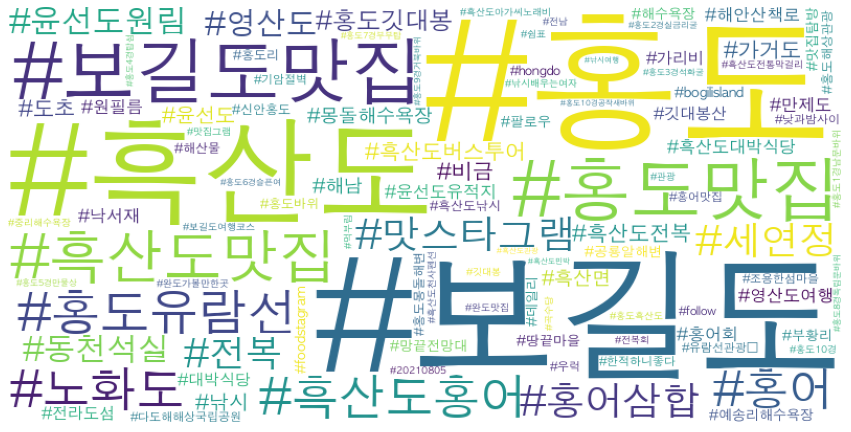

In [73]:
# 워드클라우드 만들기
wordcloud = WordCloud(font_path = font_path, background_color = 'white', max_words = 100,
                     relative_scaling = 0.3, width = 800, height = 400).generate_from_frequencies(tag_total_selected)
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig(FILE_DIR + '2_wordcloud.png')